<h1>Convolutional Neural Networks</h1>
<br>
<img src="https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png" width="900" align="center">

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [107]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 4

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "."

In [3]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

Cropping or resizing images, affine transforms and data normalizations. The torchvision module has a large number of such "transforms" which can be strung together sequentially using the "compose" function. <br>

[torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#)

In [4]:
# Prepare a composition of transforms
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

<b>Training set</b>   - the data we train our model on<br>
<b>Validation set</b> - the data we use to gauge model performance during training<br>
<b>Testing set</b>   - the data we use to "rate" our trained model<br>

In [8]:
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# Note: we can split it into to more then two pieces!
# Setting the manual seed to the same value everytime allows for saving models
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:06<00:00, 1532095.85it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1040523.75it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1891474.12it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1874498.55it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [9]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [85]:
class LeNet(nn.Module):
    def __init__(self, channels_in):
        super(LeNet, self).__init__()
        # conv1 6 channels_in x 5x5 kernels
        # nn.Conv2d (depth of input, depth of output, kernel_size)
        self.conv1 = nn.Conv2d(channels_in, out_channels = 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # nn.MaxPool2d(size of stride)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(16*5*5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
            
    def forward(self, x):
        # x = (bs, 3, 32, 32)        
        out1 = F.relu(self.conv1(x))
        # out1 shape is (bs, 6, 28, 28)
        out1 = self.maxpool(out1)
        out2 = F.relu(self.conv2(out1))
        # out2 shape is (bs, 16, 10, 10)
        out2 = self.maxpool(out2)
        # out2 shape is (bs, 16, 5, 5)
        out2 = out2.view(out2.shape[0], -1)
        out3 = F.relu(self.linear1(out2))
        out4 = F.relu(self.linear2(out3))
        out5 = self.linear3(out4)
        return out5

In [119]:
dataiter = iter(test_loader)
test_images, test_labels = next(dataiter)

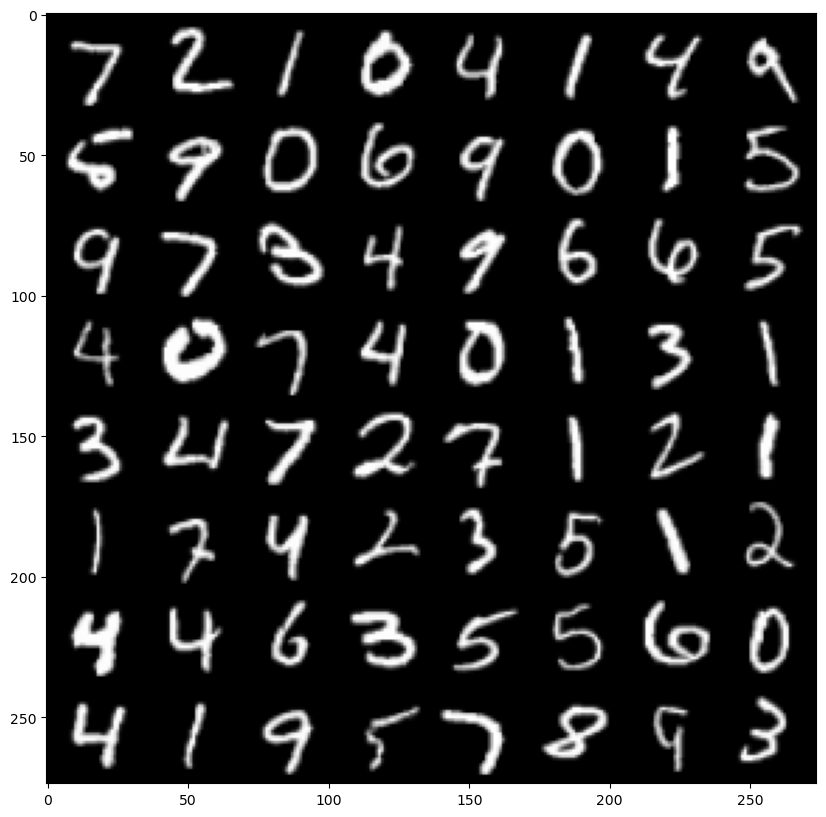

In [87]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [88]:
model = LeNet(channels_in = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fun = nn.CrossEntropyLoss()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [91]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        
        fx = model(x.to(device))
        
        loss = loss_fun(fx, y.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_logger.append(loss.item())
        
    return model, optimizer, loss_logger

In [92]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))
            
            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
    # Return the accuracy from the epoch     
    return epoch_acc / len(loader.dataset)

In [93]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [123]:
# This cell implements our training loop
for epoch in trange(num_epochs, leave=False, desc="Epoch"):
    
    model, optimizer, training_loss_logger = train(model=model, optimizer=optimizer, loader=train_loader, device=device, loss_fun=loss_fun, loss_logger=training_loss_logger)

    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'LeNet Training Loss')

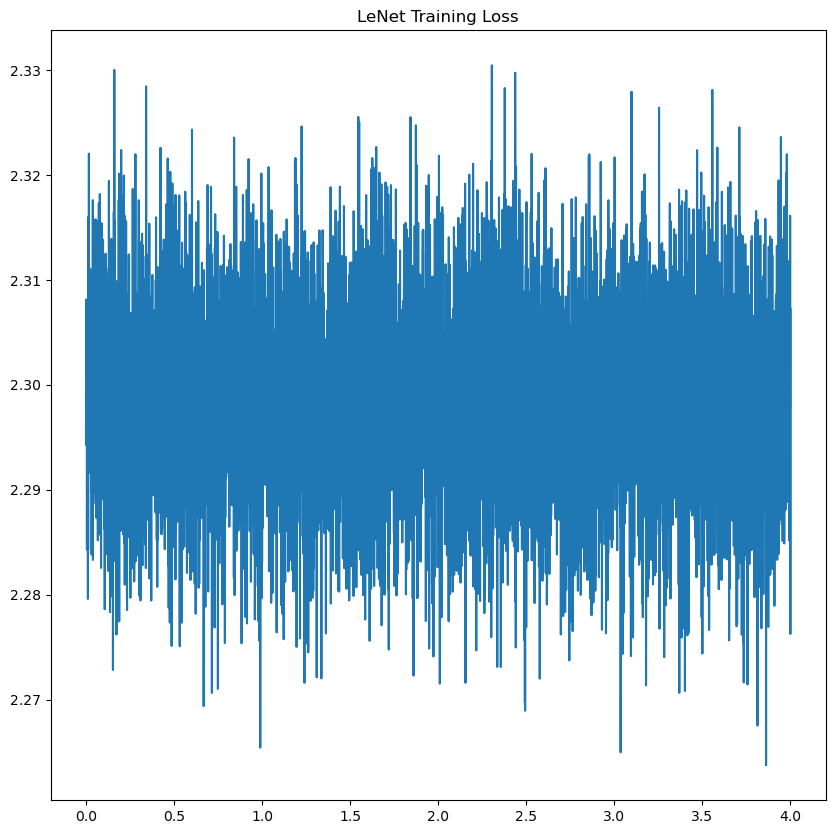

In [109]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
plt.title("LeNet Training Loss")

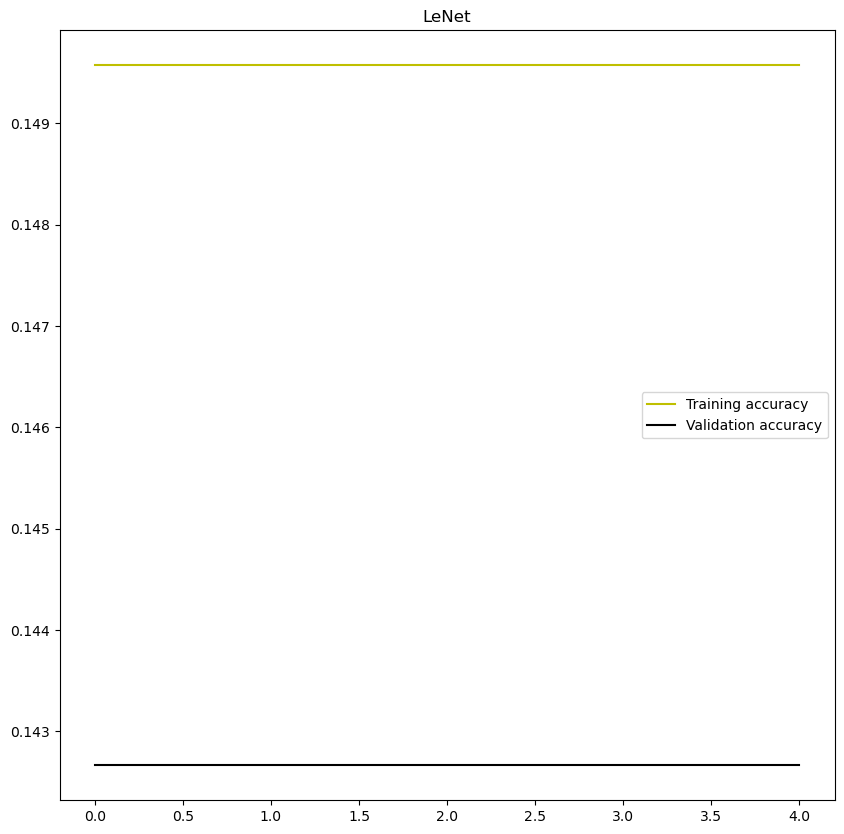

In [117]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")
plt.title("LeNet")
plt.legend(["Training accuracy", "Validation accuracy"])

In [118]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

The total test accuracy is: 15.00%


Predicted Values
 [5, 0, 5, 0, 5, 5, 5, 5]
True Values
 [7, 2, 1, 0, 4, 1, 4, 9]


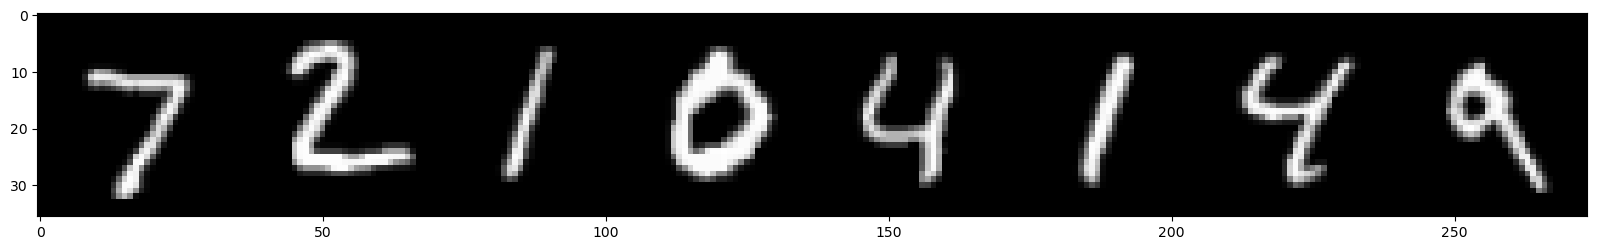

In [120]:
# Lets visualise the prediction for a few test images!
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))

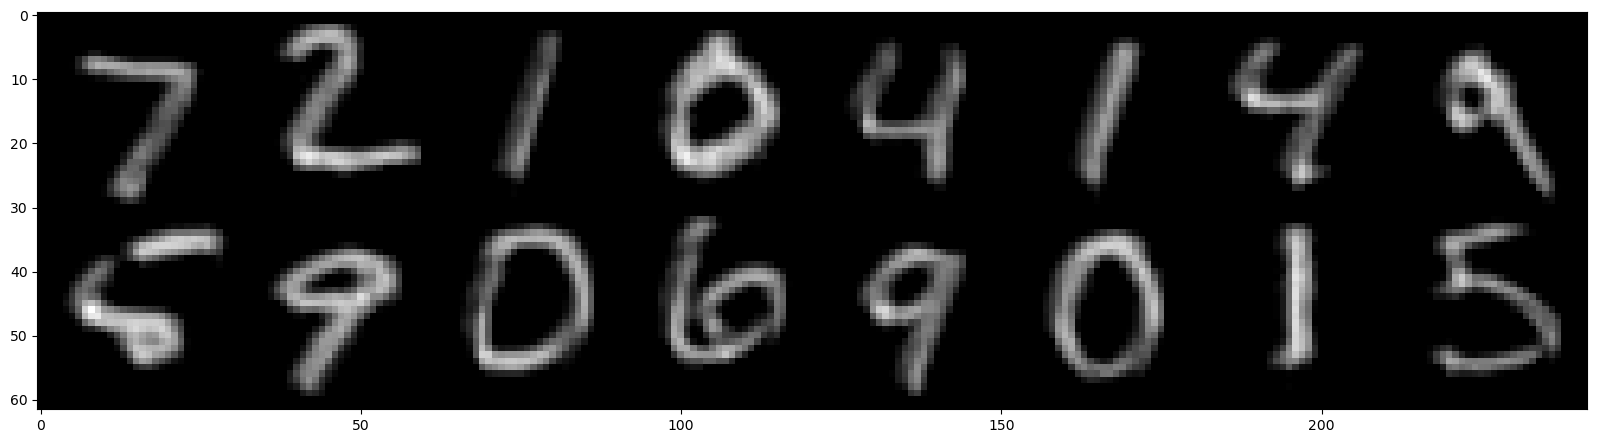

In [121]:
with torch.no_grad():
    model_out = F.relu(model.conv1(test_images.to(device)))
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(model_out[:16, 5].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

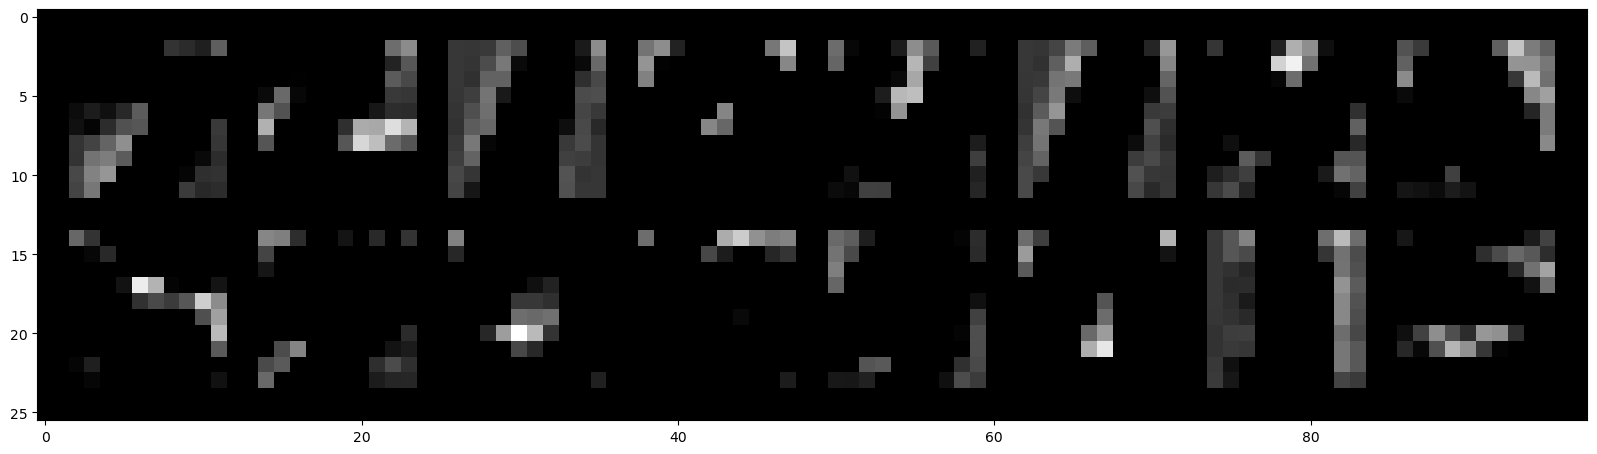

In [122]:
with torch.no_grad():
    model_out2 = F.relu(model.conv2(model.maxpool(F.relu(model.conv1(test_images.to(device))))))
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(model_out2[:16, 10].unsqueeze(1).detach().cpu(), 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))